<a href="https://colab.research.google.com/github/olyavydrina/-/blob/main/%D0%92%D0%9A%D0%A0_%D1%80%D1%83%D1%81%D1%81%D0%BA%D0%B8%D0%B9_%D1%8F%D0%B7%D1%8B%D0%BA_NLTK_%D0%BD%D0%B0_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подключаем необходимые библиотеки

In [56]:
%tensorflow_version 2.x
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
!pip install pymorphy2[fast] 
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 97.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.1/371.1 KB 38.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for DAWG: filename=DAWG-0.8.0-cp38-cp38-linux_x86_64.whl size=1316031 sha256=db866ee87f2c5f3028e49dad994cc65091b25963c79f49eb4750e5ee942100dc
  Stored in directory: /root/.cache/pip/wheels/1c/e6/8f/313a7ccc57b29a7affb7205664277a1d5ebe73bf600a69a615
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=81caeaa97e6ed2643874bf8e1f62b5aff39913b7696c1a943d71ebb4092f5733
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built DAWG docopt


In [3]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина новости
max_news_len = 300
# Количество классов новостей
nb_classes = 2

In [4]:
random_state = 42

In [5]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Загржаем и готовим набор данных

In [6]:
#!wget https://github.com/olyavydrina/-/blob/main/train2.xlsx?dl=1 -O train2.xlsx

In [ ]:
#news = pd.read_excel('train2.xlsx')

In [7]:
news = pd.read_excel('/content/train2.xlsx')
news.head()

,class,title,text,link,language
0,0,Плотник ослеп и впал в кому из-за занозы,30-летний житель английского города Сент-Остел...,https://lenta.ru/news/2022/12/12/splinter/,rus
1,1,Зеленский оценил помощь США Украине,"Президент Украины Владимир Зеленский признал, ...",https://lenta.ru/news/2022/12/12/usa/,rus
2,0,Сбившего двух пешеходов и скрывшегося с места ...,"Полицейские задержали водителя иномарки, сбивш...",https://lenta.ru/news/2022/12/12/sbil_i_uyehal/,rus
3,0,Саакашвили ограничили в курении электронных си...,Лечащие врачи бывшего президента Грузии Михаил...,https://lenta.ru/news/2022/12/12/sigaretyfu/,rus
4,0,Россиянка упала под прибывающий поезд в метро ...,Пассажирка упала на пути под прибывающий поезд...,https://lenta.ru/news/2022/12/12/metro/,rus


In [8]:
def preprocess(text, stop_words, punctuation_marks, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = morph.parse(token)[0].normal_form
            if lemma not in stop_words:
                preprocessed_text.append(lemma)
    return preprocessed_text

In [9]:
punctuation_marks = ['!', ',', '(', ')', ':', '-', '?', '.', '..', '...', '«', '»', ';', '–', '--']
stop_words = stopwords.words("russian")
morph = pymorphy2.MorphAnalyzer()

In [10]:
news['Preprocessed_texts'] = news.apply(lambda row: preprocess(row['text'], punctuation_marks, stop_words, morph), axis=1)

Считаем частоту слов во всех новостях

In [11]:
words = Counter()

In [12]:
for txt in news['Preprocessed_texts']:
    words.update(txt)

Создаем словарь, упорядоченный по частоте

В словаре будем использовать 2 специальных кода:

Код заполнитель: 0
Неизвестное слово: 1
Нумерация слов в словаре начинается с 2.

In [13]:
# Словарь, отображающий слова в коды
word_to_index = dict()
# Словарь, отображающий коды в слова
index_to_word = dict()

Создаем словари

In [14]:
for i, word in enumerate(words.most_common(num_words - 2)):
    word_to_index[word[0]] = i + 2
    index_to_word[i + 2] = word[0]

Функция для преобразования списка слов в список кодов

In [15]:
def text_to_sequence(txt, word_to_index):
    seq = []
    for word in txt:
        index = word_to_index.get(word, 1) # 1 означает неизвестное слово
        # Неизвестные слова не добавляем в выходную последовательность
        if index != 1:
            seq.append(index)
    return seq


Преобразуем все тексты в последовательность кодов слов

In [16]:
news['Sequences'] = news.apply(lambda row: text_to_sequence(row['Preprocessed_texts'], word_to_index), axis=1)

In [17]:
news

,class,title,text,link,language,Preprocessed_texts,Sequences
0,0,Плотник ослеп и впал в кому из-за занозы,30-летний житель английского города Сент-Остел...,https://lenta.ru/news/2022/12/12/splinter/,rus,"[30-летний, житель, английский, город, сента-о...","[2358, 174, 2359, 101, 2360, 2361, 2362, 2363,..."
1,1,Зеленский оценил помощь США Украине,"Президент Украины Владимир Зеленский признал, ...",https://lenta.ru/news/2022/12/12/usa/,rus,"[президент, украина, владимир, зеленский, приз...","[17, 5, 85, 311, 532, 86, 264, 533, 93, 12, 16..."
2,0,Сбившего двух пешеходов и скрывшегося с места ...,"Полицейские задержали водителя иномарки, сбивш...",https://lenta.ru/news/2022/12/12/sbil_i_uyehal/,rus,"[полицейский, задержать, водитель, иномарка, с...","[110, 105, 195, 840, 665, 177, 61, 123, 436, 6..."
3,0,Саакашвили ограничили в курении электронных си...,Лечащие врачи бывшего президента Грузии Михаил...,https://lenta.ru/news/2022/12/12/sigaretyfu/,rus,"[лечить, врач, бывший, президент, грузия, миха...","[2425, 528, 196, 17, 667, 668, 1107, 3, 72, 24..."
4,0,Россиянка упала под прибывающий поезд в метро ...,Пассажирка упала на пути под прибывающий поезд...,https://lenta.ru/news/2022/12/12/metro/,rus,"[пассажирка, упасть, путь, прибывать, поезд, м...","[1572, 377, 669, 1111, 1112, 543, 1573, 1092, ..."
...,...,...,...,...,...,...,...
109,1,Шольц назвал три причины не поставлять немецки...,"МОСКВА, 17 дек — РИА Новости. Канцлер Германии...",https://ria.ru/20221217/tanki-1839465444.html,rus,"[москва, 17, дек, —, риа, новость, канцлер, ге...","[61, 234, 430, 2, 35, 30, 277, 21, 504, 352, 2..."
110,0,"Девушка получила переломы, упав в оркестровую ...","САРАТОВ, 17 дек - РИА Новости. Зрительница упа...",https://ria.ru/20221217/konservatoriya-1839463...,rus,"[саратов, 17, дек, риа, новость, зрительница, ...","[4879, 234, 430, 35, 30, 4880, 377, 560, 2349,..."
111,1,СМИ: США пытались помешать Украине совершить п...,"ВАШИНГТОН, 18 дек - РИА Новости. Газета New Yo...",https://ria.ru/20221218/gerasimov-1839474804.html,rus,"[вашингтон, 18, дек, риа, новость, газета, new...","[129, 469, 430, 35, 30, 420, 1437, 1438, 1439,..."
112,1,Минобороны подтвердило удары по объектам на Ук...,"МОСКВА, 18 дек — РИА Новости. Министерство обо...",https://ria.ru/20221218/udar-1839474444.html,rus,"[москва, 18, дек, —, риа, новость, министерств...","[61, 469, 430, 2, 35, 30, 294, 167, 4, 551, 99..."


## Выделяем данные для обучения и тестирования

In [18]:
train, test = train_test_split(news, test_size=0.2)

In [19]:
train

,class,title,text,link,language,Preprocessed_texts,Sequences
7,0,«Русалки» спасли тонущего дайвера,"Три аквалангистки, 26-летняя Элайна Гарсия и е...",https://lenta.ru/news/2022/12/12/mermaids/,rus,"[аквалангистка, 26-летний, элайна, гарсия, кол...","[2479, 2480, 2481, 859, 1131, 1603, 1604, 1605..."
81,0,"В Челябинской области арестовали мать, бросивш...",Жительница города Чебаркуль Челябинской област...,https://ria.ru/20221212/mladenets-1838189573.html,rus,"[жительница, город, чебаркуль, челябинский, об...","[1975, 101, 1976, 3311, 165, 128, 1391, 1010, ..."
12,0,Путин встретился с главой Конституционного суда,"Президент России Владимир Путин в понедельник,...",https://lenta.ru/news/2022/12/12/const_sud/,rus,"[президент, россия, владимир, путин, понедельн...","[17, 4, 85, 58, 164, 399, 22, 46, 1151, 116, 1..."
112,1,Минобороны подтвердило удары по объектам на Ук...,"МОСКВА, 18 дек — РИА Новости. Министерство обо...",https://ria.ru/20221218/udar-1839474444.html,rus,"[москва, 18, дек, —, риа, новость, министерств...","[61, 469, 430, 2, 35, 30, 294, 167, 4, 551, 99..."
99,1,«Продолжим наносить удары по экономике России»...,Евросоюз сообщил о введении девятого по счёту ...,https://russian.rt.com/world/article/1087204-s...,rus,"[евросоюз, сообщить, введение, девятый, счёт, ...","[278, 16, 2250, 892, 145, 166, 336, 4327, 1507..."
...,...,...,...,...,...,...,...
6,0,СК подтвердил задержание сварщика и прораба по...,Следственный комитет (СК) России подтвердил за...,https://lenta.ru/news/2022/12/12/sk/,rus,"[следственный, комитет, ск, россия, подтвердит...","[323, 225, 676, 4, 551, 549, 552, 553, 45, 159..."
13,0,Устроившего пожар в «Меге» строителя задержали,"В Подмосковье задержали строителя, устроившего...",https://lenta.ru/news/2022/12/12/zaderzhali/,rus,"[подмосковье, задержать, строитель, устроить, ...","[2584, 105, 2585, 2586, 159, 702, 177, 559, 32..."
67,1,При обстреле ВСУ Горловки погиб мирный житель,"Один мирный житель погиб, еще один ранен в рез...",https://ria.ru/20221212/gorlovka-1838199188.html,rus,"[мирный, житель, погибнуть, ранить, результат,...","[740, 174, 260, 1913, 102, 776, 1358, 34, 207,..."
8,1,Австрия оценила возможность вступления Украины...,"Канцлер Австрии Карл Нехаммер заявил, что не с...",https://lenta.ru/news/2022/12/12/es/,rus,"[канцлер, австрия, карл, нехаммера, заявить, с...","[277, 1139, 1634, 2521, 10, 88, 387, 448, 5, 1..."


In [20]:
test

,class,title,text,link,language,Preprocessed_texts,Sequences
106,0,Мэрия Москвы: заболеваемость ОРВИ не помешала ...,Медицинская сестра в инфекционном отделении дл...,https://ria.ru/20221218/koronavirus-1839476045...,rus,"[медицинский, сестра, инфекционный, отделение,...","[1300, 2191, 4802, 1994, 830, 2319, 61, 469, 4..."
28,1,Матыцин прокомментировал заявление США по учас...,Министр спорта Олег Матыцин прокомментировал з...,https://lenta.ru/news/2022/12/12/matytsin/,rus,"[министр, спорт, олег, матыцин, прокомментиров...","[89, 1676, 1257, 1770, 1180, 100, 471, 225, 12..."
43,0,Сварщик и прораб задержаны по делу о пожаре в ...,«Задержаны прораб и сварщик строительно-технич...,https://russian.rt.com/russia/news/1085378-sva...,rus,"[задержать, прораб, сварщик, строительно-техни...","[105, 553, 552, 1820, 1293, 441, 555, 852, 384..."
80,0,Число погибших при обстреле Киевского района Д...,Число погибших при обстреле Киевского района Д...,https://ria.ru/20221212/obstrel-1838194852.html,rus,"[число, погибнуть, обстрел, киевский, район, д...","[67, 260, 776, 121, 133, 777, 32, 34, 207, 197..."
95,0,В России уличный кот спровоцировал аварию с тр...,В Волгоградской области животное спровоцировал...,https://lenta.ru/news/2022/12/17/kotdtp/,rus,"[волгоградский, область, животное, спровоциров...","[3975, 165, 3976, 2142, 437, 176, 126, 796, 23..."
11,1,Байден ответил на сообщения об отправке америк...,Президент США Джо Байден опроверг отправку аме...,https://lenta.ru/news/2022/12/12/neotpravlyaut/,rus,"[президент, сша, джо, байден, опровергнуть, от...","[17, 12, 398, 184, 2575, 1655, 42, 19, 5, 273,..."
32,1,Шольц выступил за сотрудничество с Россией пос...,«Канцлер Германии высказался о перспективе воз...,https://russian.rt.com/world/news/1085396-germ...,rus,"[канцлер, германия, высказаться, перспектива, ...","[277, 21, 886, 692, 953, 336, 413, 4, 739, 55,..."
104,0,Минцифры России предупредило о массовых кражах...,Об этом ведомство написало в своём Telegram. «...,https://russian.rt.com/russia/news/1087534-min...,rus,"[ведомство, написать, свой, telegram, 17, дека...","[95, 416, 15, 962, 234, 22, 691, 4676, 731, 14..."
35,0,GFG завершила продажу российского бизнеса Lamo...,Об этом говорится на сайте GFG. «GFG получила ...,https://russian.rt.com/russia/news/1085392-ros...,rus,"[говориться, сайт, gfg, gfg, получить, выручка...","[91, 458, 743, 743, 78, 1280, 1794, 2895, 959,..."
66,1,ВС России нанесли удар по живой силе противник...,Части российских Вооруженных сил Западного вое...,https://ria.ru/20221212/akatsiya-1838198014.html,rus,"[часть, российский, вооружённый, сила, западны...","[65, 20, 343, 76, 155, 19, 1351, 510, 253, 157..."


## Разделяем метки классов и данные для обучения

Данные для обучения

In [21]:
x_train = train['Sequences']
y_train = train['class']

In [22]:
x_train

7      [2479, 2480, 2481, 859, 1131, 1603, 1604, 1605...
81     [1975, 101, 1976, 3311, 165, 128, 1391, 1010, ...
12     [17, 4, 85, 58, 164, 399, 22, 46, 1151, 116, 1...
112    [61, 469, 430, 2, 35, 30, 294, 167, 4, 551, 99...
99     [278, 16, 2250, 892, 145, 166, 336, 4327, 1507...
                             ...                        
6      [323, 225, 676, 4, 551, 549, 552, 553, 45, 159...
13     [2584, 105, 2585, 2586, 159, 702, 177, 559, 32...
67     [740, 174, 260, 1913, 102, 776, 1358, 34, 207,...
8      [277, 1139, 1634, 2521, 10, 88, 387, 448, 5, 1...
70     [61, 493, 457, 28, 1295, 132, 114, 631, 157, 2...
Name: Sequences, Length: 91, dtype: object

!!! Ограничиваем длину новостных сообщений

In [23]:
x_train = pad_sequences(x_train, maxlen=max_news_len)

In [24]:
x_train

array([[   0,    0,    0, ..., 2520,   26, 1136],
       [   0,    0,    0, ..., 1982, 1387,  423],
       [   0,    0,    0, ..., 1176,   17,  143],
       ...,
       [   0,    0,    0, ..., 1915,  327,   37],
       [   0,    0,    0, ..., 1147,   80,  388],
       [   0,    0,    0, ...,    8,  160,  294]], dtype=int32)

In [25]:
y_train

7      0
81     0
12     0
112    1
99     1
      ..
6      0
13     0
67     1
8      1
70     1
Name: class, Length: 91, dtype: int64

!!! Выделяем правильные ответы (преобразуем в формат one hot encoding)

In [26]:
y_train = utils.to_categorical(y_train, nb_classes)

In [27]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

Данные для тестирования

In [28]:
x_test = test['Sequences']
y_test = test['class']

In [29]:
x_test

106    [1300, 2191, 4802, 1994, 830, 2319, 61, 469, 4...
28     [89, 1676, 1257, 1770, 1180, 100, 471, 225, 12...
43     [105, 553, 552, 1820, 1293, 441, 555, 852, 384...
80     [67, 260, 776, 121, 133, 777, 32, 34, 207, 197...
95     [3975, 165, 3976, 2142, 437, 176, 126, 796, 23...
11     [17, 12, 398, 184, 2575, 1655, 42, 19, 5, 273,...
32     [277, 21, 886, 692, 953, 336, 413, 4, 739, 55,...
104    [95, 416, 15, 962, 234, 22, 691, 4676, 731, 14...
35     [91, 458, 743, 743, 78, 1280, 1794, 2895, 959,...
66     [65, 20, 343, 76, 155, 19, 1351, 510, 253, 157...
23     [915, 347, 4, 276, 1227, 916, 2708, 2709, 347,...
55     [1840, 74, 3010, 1198, 1841, 1285, 73, 3, 3011...
93     [109, 17, 12, 398, 184, 75, 3919, 3920, 1470, ...
53     [1317, 1167, 459, 458, 460, 316, 58, 10, 696, ...
79     [45, 159, 684, 7, 559, 324, 8, 105, 553, 552, ...
47     [1825, 402, 473, 12, 74, 439, 25, 591, 19, 297...
107    [61, 469, 430, 2, 35, 30, 25, 6, 942, 239, 482...
20     [18, 225, 140, 45, 1207,

Ограничиваем длину новостных сообщений

In [30]:
x_test = pad_sequences(x_test, maxlen=max_news_len)

In [31]:
x_test

array([[   0,    0,    0, ..., 1886, 1074,  825],
       [   0,    0,    0, ..., 1183,  580, 2860],
       [   0,    0,    0, ...,  274, 2945, 2946],
       ...,
       [   0,    0,    0, ...,  192,  317, 1558],
       [   0,    0,    0, ..., 3048,  981,  200],
       [   0,    0,    0, ..., 3494,  181,  132]], dtype=int32)

In [32]:
y_test

106    0
28     1
43     0
80     0
95     0
11     1
32     1
104    0
35     0
66     1
23     0
55     1
93     1
53     0
79     0
47     1
107    0
20     1
74     0
84     1
78     0
57     1
87     1
Name: class, dtype: int64

Выделяем правильные ответы (преобразуем в формат one hot encoding)

In [33]:
y_test = utils.to_categorical(y_test, nb_classes)

In [34]:
y_test

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

## Создаем нейронную сеть с долгой краткосрочной памятью - LSTM

In [35]:
model_lstm = Sequential()
# 1-й слой - Embedding - создает плотные векторные представления слов, длина вектора - 128
model_lstm.add(Embedding(num_words, 128, input_length=max_news_len))
# 2-й и 3-й слои - LSTM - в пих по 64 и 32 ячейки
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
# 4-й слой - Выходной полносвязный слой, 2 нейрона (по количеству классов)
model_lstm.add(Dense(2, activation='sigmoid'))

создаем последовательную модель (определяем оптимизатор, функцию ошибки)

In [36]:
model_lstm.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

Выводим информацию о сети

In [37]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 300, 64)           49408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 1,341,890
Trainable params: 1,341,890
Non-trainable params: 0
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [38]:
model_lstm_save_path = '/content/best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

Обучаем нейронную сеть

In [42]:
history_lstm = model_lstm.fit(x_train,
                              y_train, 
                              epochs=5,
                              batch_size=32,
                              validation_split=0.5,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 0.2133 - accuracy: 1.0000
Epoch 1: val_accuracy did not improve from 0.67391
2/2 [==============================] - 0s 111ms/step - loss: 0.2125 - accuracy: 1.0000 - val_loss: 0.7267 - val_accuracy: 0.5870
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 0.1890 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.67391
2/2 [==============================] - 0s 72ms/step - loss: 0.1894 - accuracy: 1.0000 - val_loss: 0.8077 - val_accuracy: 0.4783
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 0.1618 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.67391
2/2 [==============================] - 0s 71ms/step - loss: 0.1704 - accuracy: 1.0000 - val_loss: 0.8380 - val_accuracy: 0.5000
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 0.1388 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 0.67391
2/2 [==============================] - 0s 65ms/

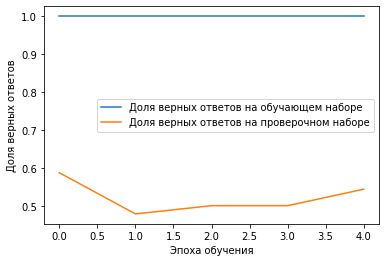

In [43]:
plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Cеть GRU

In [57]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max_news_len))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32))
model_gru.add(Dense(2, activation='sigmoid'))

In [59]:
model_gru.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [60]:
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 32)           320000    
                                                                 
 gru (GRU)                   (None, 300, 64)           18816     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 348,290
Trainable params: 348,290
Non-trainable params: 0
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл best_model_gru.h5

In [61]:
model_gru_save_path = 'best_model_gru.h5'
checkpoint_callback_gru = ModelCheckpoint(model_gru_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [65]:
history_gru = model_gru.fit(x_train, 
                              y_train, 
                              epochs=5,
                              batch_size=32,
                              validation_split=0.5,
                              callbacks=[checkpoint_callback_gru])

Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 0.0358 - accuracy: 1.0000
Epoch 1: val_accuracy did not improve from 0.60870
2/2 [==============================] - 0s 104ms/step - loss: 0.0323 - accuracy: 1.0000 - val_loss: 0.9404 - val_accuracy: 0.5435
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 0.0149 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.60870
2/2 [==============================] - 0s 72ms/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 1.3138 - val_accuracy: 0.5217
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 0.0123 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.60870
2/2 [==============================] - 0s 73ms/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 1.5906 - val_accuracy: 0.5217
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 0.0101 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 0.60870
2/2 [==============================] - 0s 59ms/

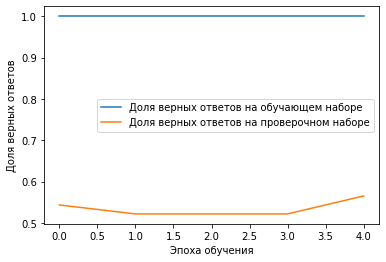

In [66]:
plt.plot(history_gru.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Сверточная нейронная сеть (CNN)

In [67]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max_news_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(2, activation='sigmoid'))

In [69]:
model_cnn.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [70]:
model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 32)           320000    
                                                                 
 conv1d (Conv1D)             (None, 296, 250)          40250     
                                                                 
 global_max_pooling1d (Globa  (None, 250)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 128)               32128     
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 392,636
Trainable params: 392,636
Non-trainable params: 0
________________________________________________

Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл best_model.h5

In [71]:
model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [76]:
history_cnn = model_cnn.fit(x_train, 
                            y_train, 
                            epochs=5,
                            batch_size=32,
                            validation_split=0.5,
                            callbacks=[checkpoint_callback_cnn])

Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 0.1468 - accuracy: 1.0000
Epoch 1: val_accuracy did not improve from 0.60870
2/2 [==============================] - 0s 53ms/step - loss: 0.1352 - accuracy: 1.0000 - val_loss: 0.6245 - val_accuracy: 0.6087
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 0.1051 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.60870
2/2 [==============================] - 0s 30ms/step - loss: 0.1065 - accuracy: 1.0000 - val_loss: 0.6240 - val_accuracy: 0.6087
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 0.0965 - accuracy: 1.0000
Epoch 3: val_accuracy improved from 0.60870 to 0.63043, saving model to best_model_cnn.h5
2/2 [==============================] - 0s 60ms/step - loss: 0.0838 - accuracy: 1.0000 - val_loss: 0.6235 - val_accuracy: 0.6304
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 0.0642 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 0.63043
2/2 [====

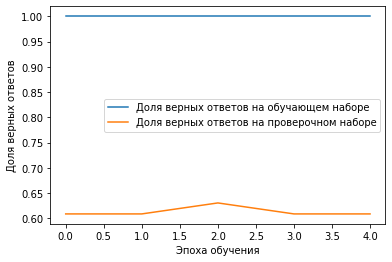

In [78]:
plt.plot(history_cnn.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Оцениваем качество работы сети на тестовом наборе данных

### Сеть LSTM

Загружаем модель с лучшей долей правильных ответов на проверочном наборе данных

In [44]:
model_lstm.load_weights(model_lstm_save_path)

Оцениваем качество работы сети на наборе данных для тестирования

In [45]:
scores = model_lstm.evaluate(x_test, y_test, verbose=1)

1/1 [==============================] - 0s 28ms/step - loss: 0.6367 - accuracy: 0.6957


In [46]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 69.5652


### Сеть GRU

In [79]:
model_gru.load_weights(model_gru_save_path)

In [81]:
scores = model_gru.evaluate(x_test, y_test, verbose=1)

1/1 [==============================] - 0s 31ms/step - loss: 0.5613 - accuracy: 0.6522


In [82]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 65.2174


### Одномерная сверточная сеть (CNN)

In [83]:
model_cnn.load_weights(model_cnn_save_path)

In [84]:
scores = model_cnn.evaluate(x_test, y_test, verbose=1)

1/1 [==============================] - 0s 35ms/step - loss: 0.5392 - accuracy: 0.6522


In [85]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 65.2174


**Оцениваем качество работы сети на новых данных**

In [47]:
text = ''' Удар украинских войск по больнице в Новоайдаре в Луганской Народной Республике является нарушением Устава ООН, заявил РИА Новости генеральный координатор сирийского центра помощи жертвам насилия и терроризма Тамер Яги. Украинские войска 28 января нанесли удар по больнице в Новоайдаре (ЛНР) из американских реактивных систем залпового огня HIMARS. Погибли 14 человек, еще 24 получили ранения, сообщило Минобороны РФ. В ведомстве отметили, что удар по гражданскому объекту является военным преступлением.'''

Преобразуем новости в числовое представление

In [48]:
text1 = preprocess(text, stop_words, punctuation_marks, morph)

In [49]:
text1

['удар',
 'украинский',
 'войско',
 'больница',
 'новоайдар',
 'луганский',
 'народный',
 'республика',
 'являться',
 'нарушение',
 'устав',
 'оон',
 'заявить',
 'риа',
 'новость',
 'генеральный',
 'координатор',
 'сирийский',
 'центр',
 'помощь',
 'жертва',
 'насилие',
 'терроризм',
 'тамер',
 'яга',
 'украинский',
 'войско',
 '28',
 'январь',
 'нанести',
 'удар',
 'больница',
 'новоайдар',
 'лнр',
 'американский',
 'реактивный',
 'система',
 'залповый',
 'огонь',
 'himars',
 'погибнуть',
 '14',
 'человек',
 'ещё',
 '24',
 'получить',
 'ранение',
 'сообщить',
 'минобороны',
 'рф',
 'ведомство',
 'отметить',
 'удар',
 'гражданский',
 'объект',
 'являться',
 'военный',
 'преступление']

In [50]:
sequence = text_to_sequence(text1, word_to_index)

In [51]:
sequence

[253,
 34,
 207,
 530,
 232,
 96,
 444,
 132,
 10,
 35,
 30,
 918,
 3017,
 177,
 51,
 982,
 3146,
 34,
 207,
 4388,
 947,
 510,
 253,
 530,
 4425,
 42,
 4232,
 71,
 4233,
 856,
 2916,
 260,
 759,
 37,
 172,
 736,
 78,
 1299,
 16,
 1198,
 38,
 95,
 57,
 253,
 799,
 217,
 96,
 19,
 1264]

In [52]:
print(text)
print(sequence)

 Удар украинских войск по больнице в Новоайдаре в Луганской Народной Республике является нарушением Устава ООН, заявил РИА Новости генеральный координатор сирийского центра помощи жертвам насилия и терроризма Тамер Яги. Украинские войска 28 января нанесли удар по больнице в Новоайдаре (ЛНР) из американских реактивных систем залпового огня HIMARS. Погибли 14 человек, еще 24 получили ранения, сообщило Минобороны РФ. В ведомстве отметили, что удар по гражданскому объекту является военным преступлением.
[253, 34, 207, 530, 232, 96, 444, 132, 10, 35, 30, 918, 3017, 177, 51, 982, 3146, 34, 207, 4388, 947, 510, 253, 530, 4425, 42, 4232, 71, 4233, 856, 2916, 260, 759, 37, 172, 736, 78, 1299, 16, 1198, 38, 95, 57, 253, 799, 217, 96, 19, 1264]


In [53]:
text2 = pad_sequences(sequence, maxlen=max_news_len)

ValueError: ignored

In [54]:
text2

NameError: ignored

Загружаем модель в память

In [ ]:
model = load_model('best_model_lstm.h5')

Запускаем распознавание (применяем сеть для определения класса новости)

In [ ]:
prediction = model.predict(text2)

ValueError: ignored

Результаты распознавания

In [ ]:
prediction

NameError: ignored

In [ ]:
prediction = np.argmax(prediction)

NameError: ignored

In [ ]:
if prediction < 0.5:
    print('Не имеет международного значения')
else:
    print('Международная новость')

NameError: ignored